In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
train_dir = 'Data/train'  
test_dir = 'Data/test'  
batch_size = 32
learning_rate = 0.001
num_epochs = 25
num_classes = len(os.listdir(train_dir))  # Assuming each folder is a class


In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize the images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the images
])


In [4]:
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [5]:
class CardClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CardClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)  # Adjust this based on image size after conv layers
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)  # Flatten the output
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [7]:
model = CardClassifier(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [8]:
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU

        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the model

        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')


Epoch 1/25, Loss: 2.8910, Accuracy: 22.14%
Epoch 2/25, Loss: 1.9970, Accuracy: 40.88%
Epoch 3/25, Loss: 1.5839, Accuracy: 53.48%
Epoch 4/25, Loss: 1.1714, Accuracy: 66.28%
Epoch 5/25, Loss: 0.8278, Accuracy: 75.85%
Epoch 6/25, Loss: 0.6469, Accuracy: 81.10%
Epoch 7/25, Loss: 0.4662, Accuracy: 85.85%
Epoch 8/25, Loss: 0.3726, Accuracy: 88.29%
Epoch 9/25, Loss: 0.3083, Accuracy: 90.91%
Epoch 10/25, Loss: 0.2432, Accuracy: 92.39%
Epoch 11/25, Loss: 0.2194, Accuracy: 93.82%
Epoch 12/25, Loss: 0.2009, Accuracy: 93.87%
Epoch 13/25, Loss: 0.1581, Accuracy: 95.42%
Epoch 14/25, Loss: 0.1442, Accuracy: 95.79%
Epoch 15/25, Loss: 0.1750, Accuracy: 95.13%
Epoch 16/25, Loss: 0.1498, Accuracy: 95.50%
Epoch 17/25, Loss: 0.1300, Accuracy: 96.27%
Epoch 18/25, Loss: 0.1240, Accuracy: 96.18%
Epoch 19/25, Loss: 0.0943, Accuracy: 97.15%
Epoch 20/25, Loss: 0.1307, Accuracy: 96.29%
Epoch 21/25, Loss: 0.1107, Accuracy: 96.85%
Epoch 22/25, Loss: 0.1078, Accuracy: 96.72%
Epoch 23/25, Loss: 0.0889, Accuracy: 97.2

In [12]:
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = datasets.ImageFolder(root='Data/valid2/', transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)



In [14]:
model.eval()  # Set the model to evaluation mode

correct_predictions = 0
total_predictions = 0

with torch.no_grad():  # Disable gradient computation for testing
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to GPU
        
        outputs = model(inputs)  # Forward pass
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

test_accuracy = correct_predictions / total_predictions * 100
print(f'Test Accuracy: {test_accuracy:.2f}%')

Test Accuracy: 88.68%


In [15]:
# Create the directory if it doesn't exist
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define the path where the model will be saved
model_path = os.path.join(model_dir, 'card_classifier.pth')

# Save the model
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to models/card_classifier.pth


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img, ax, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        ax.set_title(title, fontsize=10)

# Get predictions on the entire test set
incorrect_images = []
incorrect_labels = []
incorrect_preds = []

model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            if predicted[i] != labels[i]:  # Check if prediction is incorrect
                incorrect_images.append(inputs[i].cpu())  # Save the image
                incorrect_labels.append(labels[i].cpu())  # Save the true label
                incorrect_preds.append(predicted[i].cpu())  # Save the predicted label

# Plot the incorrect predictions
num_incorrect = len(incorrect_images)
print(num_incorrect)
if num_incorrect > 0:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.tight_layout()
    
    for idx in range(min(num_incorrect, 4)):  # Show at most 4 incorrect images
        ax = axes[idx // 2, idx % 2]
        imshow(incorrect_images[idx], ax=ax)
        ax.set_title(f"True: {train_dataset.classes[incorrect_labels[idx]]}\nPred: {train_dataset.classes[incorrect_preds[idx]]}", fontsize=10)

    plt.show()
else:
    print("No incorrect predictions to show!")



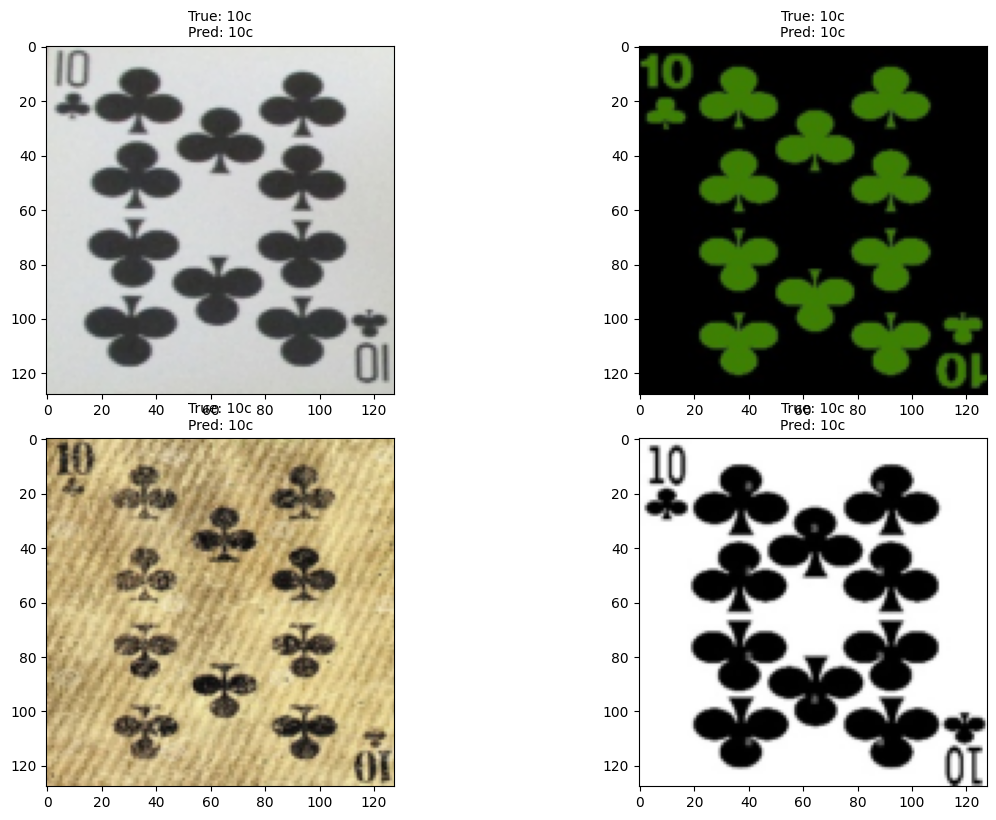

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show an image
def imshow(img, ax, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        ax.set_title(title, fontsize=10)

# Get predictions on the entire test set
correct_images = []
correct_labels = []
correct_preds = []

model.eval()  # Set the model to evaluation mode

with torch.no_grad():  # Disable gradient computation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            if predicted[i] == labels[i]:  # Check if prediction is correct
                correct_images.append(inputs[i].cpu())  # Save the image
                correct_labels.append(labels[i].cpu())  # Save the true label
                correct_preds.append(predicted[i].cpu())  # Save the predicted label

# Plot the correctly predicted samples
num_correct = len(correct_images)
if num_correct > 0:
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.tight_layout()

    for idx in range(min(num_correct, 4)):  # Show at most 4 correct images
        ax = axes[idx // 2, idx % 2]
        imshow(correct_images[idx], ax=ax)
        ax.set_title(f"True: {train_dataset.classes[correct_labels[idx]]}\nPred: {train_dataset.classes[correct_preds[idx]]}", fontsize=10)

    plt.show()
else:
    print("No correct predictions to show!")
